In [1]:
import tensorflow as tf
print(tf.__version__)

2023-03-22 13:32:28.070092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import numpy as np
import os, fnmatch
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint



In [3]:
# First we want to show to how librosa handles sound signals.
# Let's read an example audio signal using librosa
audio_file_path='siren.wav'

librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [4]:
librosa_audio_data.shape

(310905,)

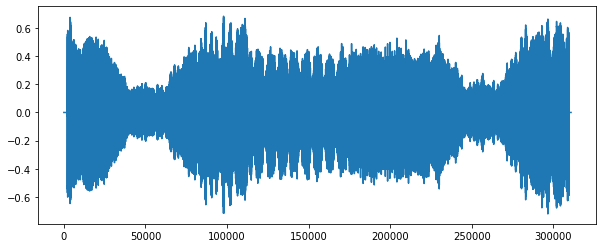

In [5]:
# Plot the librosa audio data
# Audio with 1 channel 
plt.figure(figsize=(10, 4))
plt.plot(librosa_audio_data)
plt.show()

In [6]:
librosa_sample_rate

22050

In [7]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=45)   #n_mfcc: number of MFCCs to return 
print(mfccs.shape)

(45, 608)


In [8]:
mfccs

array([[-499.8979    , -499.8979    , -499.8979    , ..., -122.37127   ,
        -207.34862   , -499.8979    ],
       [   0.        ,    0.        ,    0.        , ...,  108.84964   ,
         105.632324  ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,  -33.749146  ,
         -31.582096  ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.9861502 ,
           0.72147727,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    1.4772466 ,
           2.0283136 ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,   -3.5499961 ,
          -2.0889497 ,    0.        ]], dtype=float32)

In [9]:
# The function for extracting MFC coefficients from signals using librosa:

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=45)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)    
    return mfccs_scaled_features

In [10]:
# In order to find all the files in directory:
def find_files(directory, pattern):
    for root, dirs, files in os.walk(directory):
        for basename in files:
            if fnmatch.fnmatch(basename, pattern):
                filename = os.path.join(root, basename)
                yield filename


dataset =[]                
                
for filename in find_files("audio", "*.wav"):    
#    print("Found wav source:", filename)
    label = filename.split(".wav")[0][-5]
    if label == '-':
        label = filename.split(".wav")[0][-6]
    dataset.append({"file_name" : filename, "label" : label})
  
    
    
dataset

[{'file_name': 'audio/fold2/203929-7-5-1.wav', 'label': '7'},
 {'file_name': 'audio/fold2/196384-9-0-2.wav', 'label': '9'},
 {'file_name': 'audio/fold2/169098-7-4-6.wav', 'label': '7'},
 {'file_name': 'audio/fold2/123688-8-0-4.wav', 'label': '8'},
 {'file_name': 'audio/fold2/174994-3-0-0.wav', 'label': '3'},
 {'file_name': 'audio/fold2/18453-3-0-0.wav', 'label': '3'},
 {'file_name': 'audio/fold2/109703-2-0-134.wav', 'label': '0'},
 {'file_name': 'audio/fold2/147926-0-0-44.wav', 'label': '0'},
 {'file_name': 'audio/fold2/123688-8-0-13.wav', 'label': '8'},
 {'file_name': 'audio/fold2/203929-7-7-3.wav', 'label': '7'},
 {'file_name': 'audio/fold2/147926-0-0-50.wav', 'label': '0'},
 {'file_name': 'audio/fold2/169098-7-4-11.wav', 'label': '7'},
 {'file_name': 'audio/fold2/98202-9-0-10.wav', 'label': '9'},
 {'file_name': 'audio/fold2/156893-7-6-0.wav', 'label': '7'},
 {'file_name': 'audio/fold2/189023-0-0-0.wav', 'label': '0'},
 {'file_name': 'audio/fold2/203929-7-6-10.wav', 'label': '7'},
 {

In [11]:
dataset = pd.DataFrame(dataset)

dataset.head()


,file_name,label
0,audio/fold2/203929-7-5-1.wav,7
1,audio/fold2/196384-9-0-2.wav,9
2,audio/fold2/169098-7-4-6.wav,7
3,audio/fold2/123688-8-0-4.wav,8
4,audio/fold2/174994-3-0-0.wav,3


In [12]:
dataset.shape

(8732, 2)

In [13]:
# Let's iterate every sound file and extract features using MFC Coefficients of librosa 
# using features_extractor method we defined above:
extracted_features=[]

dataset['data'] = dataset['file_name'].apply(features_extractor)


/Users/prakhyatshrestha/opt/anaconda3/envs/tarp/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
/Users/prakhyatshrestha/opt/anaconda3/envs/tarp/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Users/prakhyatshrestha/opt/anaconda3/envs/tarp/lib/python3.10/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [14]:
dataset.head()

,file_name,label,data
0,audio/fold2/203929-7-5-1.wav,7,"[-153.31117, 174.35437, -33.579758, 28.194859,..."
1,audio/fold2/196384-9-0-2.wav,9,"[-122.62848, 98.15081, 22.81033, 14.62706, 1.6..."
2,audio/fold2/169098-7-4-6.wav,7,"[-113.39708, 133.08368, -13.934238, 17.539791,..."
3,audio/fold2/123688-8-0-4.wav,8,"[-338.18646, 134.56207, -29.537827, 22.396292,..."
4,audio/fold2/174994-3-0-0.wav,3,"[-317.8615, 52.27125, -46.80699, -1.7333952, -..."


In [15]:
# Let's change column names:
dataset = dataset.rename(columns={'label': 'class'})
dataset = dataset.rename(columns={'data': 'feature'})

In [16]:
dataset.head()

,file_name,class,feature
0,audio/fold2/203929-7-5-1.wav,7,"[-153.31117, 174.35437, -33.579758, 28.194859,..."
1,audio/fold2/196384-9-0-2.wav,9,"[-122.62848, 98.15081, 22.81033, 14.62706, 1.6..."
2,audio/fold2/169098-7-4-6.wav,7,"[-113.39708, 133.08368, -13.934238, 17.539791,..."
3,audio/fold2/123688-8-0-4.wav,8,"[-338.18646, 134.56207, -29.537827, 22.396292,..."
4,audio/fold2/174994-3-0-0.wav,3,"[-317.8615, 52.27125, -46.80699, -1.7333952, -..."


In [17]:
# Dropping unnecessary column from dataframe..
dataset.drop(['file_name'], axis=1, inplace=True)

In [18]:
dataset.head()

,class,feature
0,7,"[-153.31117, 174.35437, -33.579758, 28.194859,..."
1,9,"[-122.62848, 98.15081, 22.81033, 14.62706, 1.6..."
2,7,"[-113.39708, 133.08368, -13.934238, 17.539791,..."
3,8,"[-338.18646, 134.56207, -29.537827, 22.396292,..."
4,3,"[-317.8615, 52.27125, -46.80699, -1.7333952, -..."


In [19]:
# We will convert extracted_features to Pandas dataframe
extracted_features_df = pd.DataFrame(dataset,columns=['class','feature'])
extracted_features_df.head()

,class,feature
0,7,"[-153.31117, 174.35437, -33.579758, 28.194859,..."
1,9,"[-122.62848, 98.15081, 22.81033, 14.62706, 1.6..."
2,7,"[-113.39708, 133.08368, -13.934238, 17.539791,..."
3,8,"[-338.18646, 134.56207, -29.537827, 22.396292,..."
4,3,"[-317.8615, 52.27125, -46.80699, -1.7333952, -..."


In [20]:
# We then split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [21]:
X.shape

(8732, 45)

In [22]:
X

array([[-1.5331117e+02,  1.7435437e+02, -3.3579758e+01, ...,
        -5.0225902e-01, -3.9603736e+00,  2.9388754e+00],
       [-1.2262848e+02,  9.8150810e+01,  2.2810329e+01, ...,
         4.7464952e+00, -4.0669475e+00, -1.7328404e+00],
       [-1.1339708e+02,  1.3308368e+02, -1.3934238e+01, ...,
        -4.7859182e+00, -9.1339636e+00, -3.5373797e+00],
       ...,
       [-3.9577615e+02,  1.1766896e+02, -1.8984079e+01, ...,
         1.1930171e+00, -3.3352229e-01,  8.4444962e-02],
       [-1.4109282e+02,  4.5605965e+01, -3.0348949e+01, ...,
        -2.9537885e+00,  8.1303328e-01, -2.9190287e-01],
       [-3.3148029e+02,  7.4129967e+01, -8.5728676e+01, ...,
         1.8560742e+00, -2.1112416e+00, -3.9246848e-01]], dtype=float32)

In [23]:
y

array(['7', '9', '7', ..., '8', '4', '2'], dtype='<U1')

In [24]:
y.shape

(8732,)

In [25]:
# We should perform Label Encoding since we need one hot encoded values for output classes in our model (1s and 0s)

# 1 0 0 0 0 0 0 0 0 0 => air_conditioner
# 0 1 0 0 0 0 0 0 0 0 => car_horn
# 0 0 1 0 0 0 0 0 0 0 => children_playing
# 0 0 0 1 0 0 0 0 0 0 => dog_bark
# ...
# 0 0 0 0 0 0 0 0 0 1 => street_music

labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [26]:
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [27]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [28]:
# We split dataset as Train and Test

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [29]:

X_train

array([[-2.7296402e+02,  6.0375450e+01, -5.7678921e+01, ...,
        -2.5575006e+00, -1.5733846e+00, -1.1596335e+00],
       [-2.6632727e+02,  1.5543475e+02, -2.4472509e+01, ...,
        -1.2297513e+00, -2.9184153e+00,  5.5799019e-01],
       [-2.2991238e+02,  2.4417261e+01, -2.7639660e+01, ...,
        -5.2059345e+00, -8.4674299e-01, -4.6233258e+00],
       ...,
       [-7.2083813e+02,  1.5226428e+02,  2.4137730e+01, ...,
        -7.9580098e-01, -2.0780714e+00, -1.5212320e-01],
       [-2.0899434e+02,  1.7680823e+02,  1.8007748e-01, ...,
         7.6561298e+00,  6.4269364e-01, -8.5991132e-01],
       [-1.7071497e+02,  5.9605366e+01, -1.1798903e+02, ...,
         2.2253144e+00,  4.0549650e+00,  1.8291647e+00]], dtype=float32)

In [30]:
y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [31]:
X_train.shape

(6985, 45)

In [32]:
X_test.shape

(1747, 45)

In [33]:
y_train.shape

(6985, 10)

In [34]:
y_test.shape

(1747, 10)

In [35]:
num_labels = 10

In [36]:
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
# Now we start building our CNN model..

model=Sequential()
# 1. hidden layer
model.add(Dense(125,input_shape=(45,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 2. hidden layer
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 3. hidden layer
model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

2023-03-22 13:41:43.515772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               5750      
                                                                 
 activation (Activation)     (None, 125)               0         
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               31500     
                                                                 
 activation_1 (Activation)   (None, 250)               0         
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 125)               3

In [38]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [39]:
# Trianing the model

epochscount = 300
num_batch_size = 32

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)


Epoch 1/300
219/219 [==============================] - 2s 3ms/step - loss: 9.2259 - accuracy: 0.1203 - val_loss: 2.2869 - val_accuracy: 0.1202
Epoch 2/300
219/219 [==============================] - 0s 2ms/step - loss: 2.4735 - accuracy: 0.1281 - val_loss: 2.2599 - val_accuracy: 0.1414
Epoch 3/300
219/219 [==============================] - 0s 2ms/step - loss: 2.2859 - accuracy: 0.1694 - val_loss: 2.1900 - val_accuracy: 0.1923
Epoch 4/300
219/219 [==============================] - 0s 2ms/step - loss: 2.2328 - accuracy: 0.1771 - val_loss: 2.1657 - val_accuracy: 0.1952
Epoch 5/300
219/219 [==============================] - 0s 2ms/step - loss: 2.1706 - accuracy: 0.1960 - val_loss: 2.1009 - val_accuracy: 0.2009
Epoch 6/300
219/219 [==============================] - 0s 2ms/step - loss: 2.1227 - accuracy: 0.2110 - val_loss: 2.0208 - val_accuracy: 0.2725
Epoch 7/300
219/219 [==============================] - 0s 2ms/step - loss: 2.0556 - accuracy: 0.2389 - val_loss: 1.9713 - val_accuracy: 0.3017

Epoch 58/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9957 - accuracy: 0.6710 - val_loss: 0.8732 - val_accuracy: 0.7293
Epoch 59/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9783 - accuracy: 0.6744 - val_loss: 0.8806 - val_accuracy: 0.7384
Epoch 60/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9624 - accuracy: 0.6769 - val_loss: 0.8528 - val_accuracy: 0.7390
Epoch 61/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9629 - accuracy: 0.6790 - val_loss: 0.8546 - val_accuracy: 0.7338
Epoch 62/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9783 - accuracy: 0.6674 - val_loss: 0.8711 - val_accuracy: 0.7367
Epoch 63/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9658 - accuracy: 0.6757 - val_loss: 0.8342 - val_accuracy: 0.7481
Epoch 64/300
219/219 [==============================] - 0s 2ms/step - loss: 0.9584 - accuracy: 0.6810 - val_loss: 0.8545 - val_accuracy:

Epoch 115/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8763 - accuracy: 0.7141 - val_loss: 0.7418 - val_accuracy: 0.7716
Epoch 116/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8457 - accuracy: 0.7207 - val_loss: 0.7428 - val_accuracy: 0.7739
Epoch 117/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8391 - accuracy: 0.7246 - val_loss: 0.7356 - val_accuracy: 0.7722
Epoch 118/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8237 - accuracy: 0.7243 - val_loss: 0.7631 - val_accuracy: 0.7636
Epoch 119/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8410 - accuracy: 0.7207 - val_loss: 0.7511 - val_accuracy: 0.7699
Epoch 120/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8401 - accuracy: 0.7203 - val_loss: 0.7274 - val_accuracy: 0.7722
Epoch 121/300
219/219 [==============================] - 0s 2ms/step - loss: 0.8474 - accuracy: 0.7204 - val_loss: 0.7485 - val_ac

219/219 [==============================] - 0s 2ms/step - loss: 0.8105 - accuracy: 0.7349 - val_loss: 0.6866 - val_accuracy: 0.7859
Epoch 172/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7871 - accuracy: 0.7373 - val_loss: 0.7055 - val_accuracy: 0.7825
Epoch 173/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7902 - accuracy: 0.7404 - val_loss: 0.7252 - val_accuracy: 0.7682
Epoch 174/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7966 - accuracy: 0.7310 - val_loss: 0.7004 - val_accuracy: 0.7928
Epoch 175/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7792 - accuracy: 0.7380 - val_loss: 0.6870 - val_accuracy: 0.7865
Epoch 176/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7840 - accuracy: 0.7426 - val_loss: 0.6895 - val_accuracy: 0.7911
Epoch 177/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7915 - accuracy: 0.7394 - val_loss: 0.7031 - val_accuracy: 0.7882

219/219 [==============================] - 0s 2ms/step - loss: 0.7684 - accuracy: 0.7490 - val_loss: 0.6592 - val_accuracy: 0.7968
Epoch 228/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7703 - accuracy: 0.7440 - val_loss: 0.6847 - val_accuracy: 0.8037
Epoch 229/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7701 - accuracy: 0.7390 - val_loss: 0.6568 - val_accuracy: 0.7951
Epoch 230/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7860 - accuracy: 0.7414 - val_loss: 0.6735 - val_accuracy: 0.7997
Epoch 231/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7746 - accuracy: 0.7460 - val_loss: 0.6624 - val_accuracy: 0.8042
Epoch 232/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7458 - accuracy: 0.7479 - val_loss: 0.6528 - val_accuracy: 0.7985
Epoch 233/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7638 - accuracy: 0.7476 - val_loss: 0.6607 - val_accuracy: 0.8014

219/219 [==============================] - 0s 2ms/step - loss: 0.7427 - accuracy: 0.7529 - val_loss: 0.6460 - val_accuracy: 0.8019
Epoch 284/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7473 - accuracy: 0.7566 - val_loss: 0.6352 - val_accuracy: 0.8082
Epoch 285/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7385 - accuracy: 0.7493 - val_loss: 0.6853 - val_accuracy: 0.7934
Epoch 286/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7360 - accuracy: 0.7568 - val_loss: 0.6460 - val_accuracy: 0.8082
Epoch 287/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7426 - accuracy: 0.7525 - val_loss: 0.6443 - val_accuracy: 0.8100
Epoch 288/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7422 - accuracy: 0.7589 - val_loss: 0.6650 - val_accuracy: 0.7934
Epoch 289/300
219/219 [==============================] - 0s 2ms/step - loss: 0.7352 - accuracy: 0.7593 - val_loss: 0.6378 - val_accuracy: 0.8077

In [40]:
validation_test_set_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy[1])

0.8088151216506958


In [41]:
X_test[1]

array([-2.03061951e+02,  1.43919724e+02, -2.85614223e+01,  4.42138710e+01,
        1.29057360e+01,  1.63904152e+01,  8.55105019e+00,  1.42334185e+01,
       -5.29475033e-01,  1.68827877e+01, -2.42014527e+00,  5.23362637e+00,
       -3.34639883e+00,  2.50043925e-02,  3.36288857e+00,  7.68426609e+00,
        8.14569855e+00,  2.96838450e+00, -6.79639673e+00, -4.77808571e+00,
       -2.80781698e+00, -1.72081530e+00, -2.90645194e+00, -6.79796171e+00,
       -7.39094400e+00, -5.81671906e+00, -2.41702032e+00, -9.37182903e+00,
       -4.63835430e+00,  4.00018692e+00,  1.09147835e+01,  1.91835153e+00,
       -2.41982365e+00,  4.17242622e+00,  3.49988818e+00, -1.23318994e+00,
       -3.01415420e+00,  2.90617156e+00, -6.52086496e+00, -1.55707445e+01,
       -2.37999773e+00,  3.83459473e+00, -5.74738026e+00, -6.52352858e+00,
        3.81297922e+00], dtype=float32)

In [42]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

55/55 [==============================] - 0s 871us/step


In [43]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline
from IPython.display import Audio, IFrame, display
import librosa.display

/Users/prakhyatshrestha/opt/anaconda3/envs/tarp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
sr = 16000
e_file1 = 'bark.wav'
data,rate = librosa.load(e_file1, mono=True, sr=sr, offset=0, duration=10)

In [45]:
display(Audio(data, rate=rate))

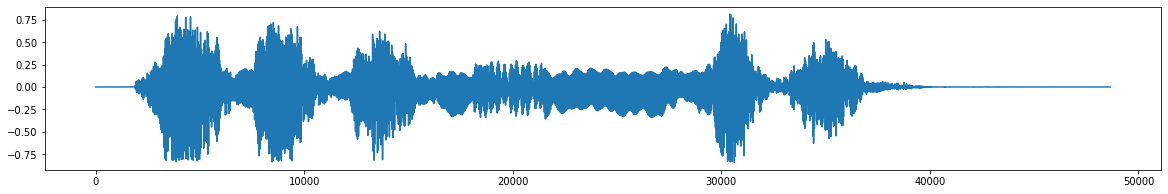

In [46]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data)

In [47]:
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*10
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

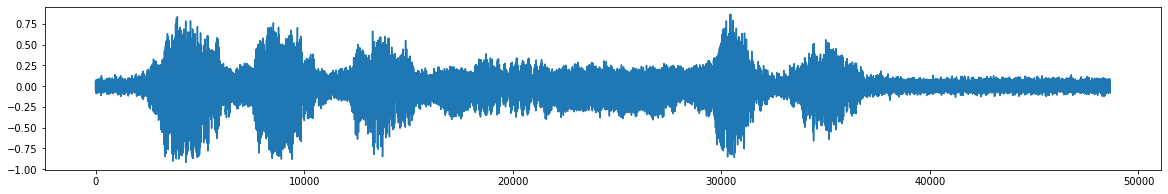

In [48]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [49]:
IPython.display.Audio(data=audio_clip_band_limited, rate=rate)

In [50]:
reduced_noise = nr.reduce_noise(y = audio_clip_band_limited, sr=rate, n_std_thresh_stationary=1.5,stationary=True)

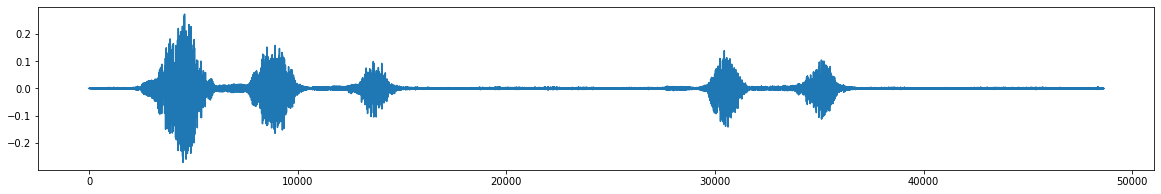

In [51]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(reduced_noise)

In [52]:
IPython.display.Audio(data=reduced_noise, rate=rate)

In [53]:
sf.write('reduced_bark.wav', reduced_noise,sr)

In [54]:
filename="reduced_bark.wav"
sound_signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=45)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

In [55]:
print(mfccs_scaled_features)

[-5.14373596e+02  2.60875454e+01 -2.53596897e+01  3.73933830e+01
 -3.50389481e+01 -1.58581388e+00 -1.87523365e+01  1.05635214e+01
 -2.65534854e+00 -1.75054245e+01 -6.44594908e+00 -1.47330933e+01
  2.66080928e+00 -1.42413025e+01 -2.77125931e+00 -5.81807137e+00
 -2.04614258e+00  2.67320013e+00 -1.07987151e-01  7.38274336e+00
 -1.86216009e+00  6.99622750e-01 -3.71366310e+00  1.21286905e+00
  1.63075775e-01 -8.57150495e-01 -7.81697512e-01 -2.02486992e-01
  2.39666986e+00 -3.47402453e+00  5.15503311e+00  2.64135927e-01
 -8.76109004e-01  1.06025621e-01 -3.00386620e+00  1.37444869e-01
 -7.70248532e-01  4.19019163e-01 -2.01830101e+00 -9.38176334e-01
 -9.82088149e-01  2.39151809e-02  4.64967579e-01 -9.08736706e-01
 -3.52145761e-01]


In [56]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)

In [57]:
mfccs_scaled_features.shape

(1, 45)

In [58]:
print(mfccs_scaled_features)

[[-5.14373596e+02  2.60875454e+01 -2.53596897e+01  3.73933830e+01
  -3.50389481e+01 -1.58581388e+00 -1.87523365e+01  1.05635214e+01
  -2.65534854e+00 -1.75054245e+01 -6.44594908e+00 -1.47330933e+01
   2.66080928e+00 -1.42413025e+01 -2.77125931e+00 -5.81807137e+00
  -2.04614258e+00  2.67320013e+00 -1.07987151e-01  7.38274336e+00
  -1.86216009e+00  6.99622750e-01 -3.71366310e+00  1.21286905e+00
   1.63075775e-01 -8.57150495e-01 -7.81697512e-01 -2.02486992e-01
   2.39666986e+00 -3.47402453e+00  5.15503311e+00  2.64135927e-01
  -8.76109004e-01  1.06025621e-01 -3.00386620e+00  1.37444869e-01
  -7.70248532e-01  4.19019163e-01 -2.01830101e+00 -9.38176334e-01
  -9.82088149e-01  2.39151809e-02  4.64967579e-01 -9.08736706e-01
  -3.52145761e-01]]


In [59]:
print(mfccs_scaled_features.shape)

(1, 45)


In [60]:
result_array = model.predict(mfccs_scaled_features)

1/1 [==============================] - 0s 22ms/step


In [61]:
result_array

array([[2.4238864e-03, 7.6878996e-04, 6.0215417e-02, 4.6582115e-01,
        7.3614568e-03, 9.3534785e-05, 4.5814988e-01, 2.8438896e-07,
        4.0807026e-03, 1.0849009e-03]], dtype=float32)

In [62]:
result_classes = ["air_conditioner","car_horn","children_playing","dog_bark","drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

result = np.argmax(result_array[0])
print(result_classes[result]) 

dog_bark


55/55 [==============================] - 0s 865us/step
[[166   0  40   1   1   1   0   2   2  12]
 [  1  73   0   2   1   2   0   3   3   9]
 [  9   0 147   4   2   1   0   1   3   6]
 [  1   0  27 151   3   1   2   1  10  10]
 [  0   0   4   6 177   0   0   3   0   3]
 [  3   0  10   1   2 174   0   1   3   2]
 [  3   0   9  12   0   0  44   0   2   0]
 [  3   0   0   0   5   0   0 185   0   5]
 [  0   0  15   5   3   1   0   0 168   2]
 [  9   1  35   7   7   2   0   5   4 128]]


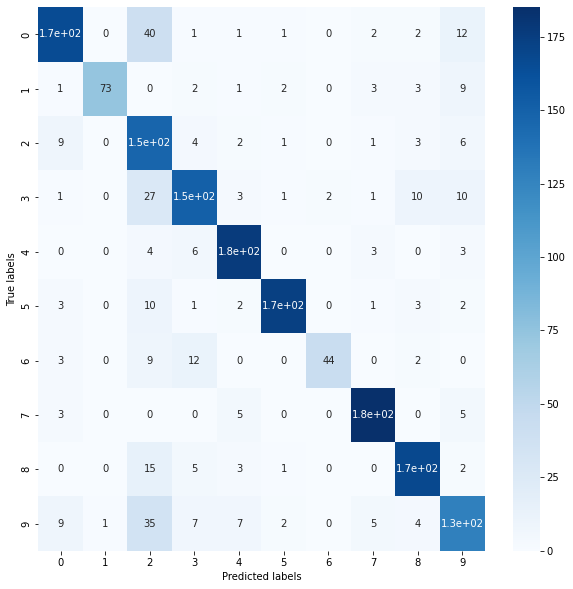

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels for the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert the true labels to integers
y_test_int = np.argmax(y_test, axis=1)

# Get the confusion matrix
cm = confusion_matrix(y_test_int, y_pred)
print(cm)


# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


In [64]:
from sklearn.metrics import classification_report
report = classification_report(y_test_int, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.74      0.79       225
           1       0.99      0.78      0.87        94
           2       0.51      0.85      0.64       173
           3       0.80      0.73      0.76       206
           4       0.88      0.92      0.90       193
           5       0.96      0.89      0.92       196
           6       0.96      0.63      0.76        70
           7       0.92      0.93      0.93       198
           8       0.86      0.87      0.86       194
           9       0.72      0.65      0.68       198

    accuracy                           0.81      1747
   macro avg       0.84      0.80      0.81      1747
weighted avg       0.83      0.81      0.81      1747



In [65]:
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test set accuracy:", accuracy)

Test set accuracy: 0.8088151216506958
